# Transfer learning


In [1]:
!ls

sample_data


In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
%matplotlib inline

import numpy as np
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Activation, Dropout, Flatten, Dense ,GlobalAveragePooling2D
from keras.layers import Convolution2D, MaxPooling2D
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import glob
import pandas as pd
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt



sns.set()

In [13]:
train_data_dir = "/content/train"
validation_data_dir = "/content/validation"
test_data_dir = "/content/test1"

nb_train_samples = 16099
nb_validation_samples = 973 
nb_test_samples = 2486
epochs = 50
batch_size = 32

!mkdir /content/Models

mkdir: cannot create directory ‘/content/Models’: File exists


In [0]:
   def  init_generators( size ):  
    datagen = ImageDataGenerator(rescale=1. / (size+1))
     #train generator
    global generator
    generator = datagen.flow_from_directory(
           train_data_dir,
           target_size=(size, size),
           batch_size=1,
           class_mode=None,
           shuffle=False)
    #validation generator
    global generator2
    generator2 = datagen.flow_from_directory(
          validation_data_dir,
          target_size=(size, size),
          batch_size=1,
          class_mode=None,
          shuffle=False)    
     #test generator
    global generator3
    generator3 = datagen.flow_from_directory(
          test_data_dir,
          target_size=(size, size),
          batch_size=1,
          class_mode=None,
          shuffle=False)

In [0]:
def save_bottleneck_features( model, name):
    #getting the bottlneck featurs and save in files
      
    bottleneck_features_train = model.predict_generator(generator, nb_train_samples)

    np.save(open('/content/bottleneck_features_train_'+name+'.npy', 'wb'),bottleneck_features_train)

     #validation

    bottleneck_features_validation = model.predict_generator(generator2, nb_validation_samples)
    
    np.save(open('/content/bottleneck_features_validation_'+name+'.npy', 'wb'),bottleneck_features_validation)

    bottleneck_features_test = model.predict_generator(generator3, nb_test_samples)

    np.save(open('/content/bottleneck_features_test_'+name+'.npy', 'wb'),bottleneck_features_test)

In [0]:
def train_top_model(name,optimizer):
  #Early stopping
  early_stopping = EarlyStopping(monitor='val_acc', verbose=1, patience=8)
  checkpointer = ModelCheckpoint(filepath='/content/Models/'+name+'.h5', monitor='val_acc', verbose=1, save_best_only=True)
  num_classes = len(generator.class_indices)

  #load saved bottleneck features
  train_data = np.load(open('/content/bottleneck_features_train_'+name+'.npy','rb'))
  train_labels = to_categorical(generator.classes[:16099], num_classes=num_classes)
  validation_data = np.load(open('/content/bottleneck_features_validation_'+name+'.npy','rb'))
  validation_labels  = to_categorical(generator2.classes[:973], num_classes=num_classes)
  
  #Sample training model
  model = Sequential()
  model.add(Dense(256, activation='relu',input_shape=train_data.shape[1:]))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))
  
  model.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])
  model.summary()
  model_json = model.to_json()
  with open(name+"_model.json", "w") as json_file:
    json_file.write(model_json)  
  global history
  history = model.fit(train_data, train_labels, epochs=epochs, batch_size=32, validation_data=(validation_data, validation_labels),
         callbacks=[early_stopping,checkpointer],
        verbose=2)
  return model

In [0]:
def test_top_model(model,name,labels_num):
  num_classes = len(generator.class_indices)

  test_data = np.load(open('/content/bottleneck_features_test_'+name+'.npy','rb'))
  test_labels  = to_categorical(generator3.classes[:labels_num], num_classes=num_classes)
  model.load_weights('/content/Models/'+name+'.h5')
  # loss and accuracy
  print(model.evaluate(test_data, test_labels))

# Pretrained Model VGG16


##Save Bottleneck Features

In [0]:
VGG16_model = applications.VGG16(include_top=False, weights='imagenet',pooling='avg')

In [22]:
init_generators(224)

Found 16099 images belonging to 10 classes.
Found 973 images belonging to 10 classes.
Found 2486 images belonging to 10 classes.


In [0]:
save_bottleneck_features( VGG16_model, "VGG16")

In [32]:
sgd = optimizers.SGD(lr=0.01, clipnorm=1.,momentum=0.7)
top_model = train_top_model("VGG16",sgd)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2570      
Total params: 133,898
Trainable params: 133,898
Non-trainable params: 0
_________________________________________________________________
Train on 16099 samples, validate on 973 samples
Epoch 1/50
 - 3s - loss: 1.9794 - acc: 0.3813 - val_loss: 1.6326 - val_acc: 0.5848

Epoch 00001: val_acc improved from -inf to 0.58479, saving model to /content/Models/VGG16.h5
Epoch 2/50
 - 3s - loss: 1.4497 - acc: 0.5941 - val_loss: 1.2296 - val_acc: 0.6978

Epoch 00002: val_acc improved from 0.58479 to 0.69784, saving model to /content/Models/VGG1

In [36]:

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'VGG16_before.h5'})
uploaded.SetContentFile('/content/Models/VGG16.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1si9SHJmJfubcAKKCwmHqDcL-IVRvq30v


In [37]:
top_model.load_weights("/content/Models/VGG16.h5")
#loss and accuracy
test_top_model(top_model,"VGG16",2486)

2486/2486 [==============================] - 0s 63us/step
[0.3359857300118103, 0.8913917942864226]


## Visualization

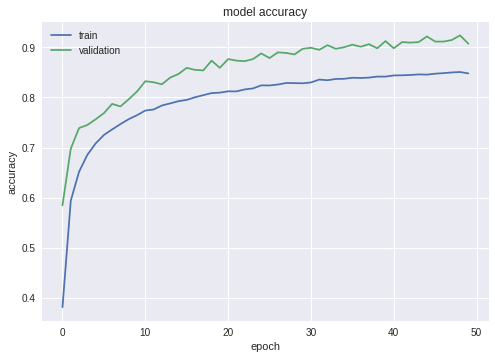

In [38]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


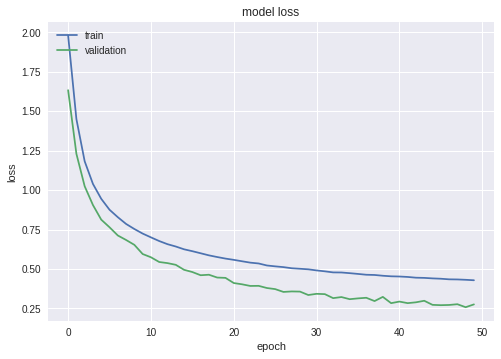

In [39]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## After Refinment

In [40]:
RMS = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
top_model = train_top_model("VGG16",RMS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)                2570      
Total params: 133,898
Trainable params: 133,898
Non-trainable params: 0
_________________________________________________________________
Train on 16099 samples, validate on 973 samples
Epoch 1/50
 - 3s - loss: 1.0367 - acc: 0.6779 - val_loss: 0.5964 - val_acc: 0.8047

Epoch 00001: val_acc improved from -inf to 0.80473, saving model to /content/Models/VGG16.h5
Epoch 2/50
 - 2s - loss: 0.5604 - acc: 0.8163 - val_loss: 0.5046 - val_acc: 0.8201

Epoch 00002: val_acc improved from 0.80473 to 0.82014, saving model to /content/Models/VGG1

In [41]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'VGG16_after.h5'})
uploaded.SetContentFile('/content/Models/VGG16.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1rRvFfoyEk3n8Xdlyoj7JfkF3TVUJFAE6


In [42]:
top_model.load_weights("/content/Models/VGG16.h5")
#loss and accuracy
test_top_model(top_model,"VGG16",2486)

2486/2486 [==============================] - 0s 68us/step
[0.2718967391838854, 0.9304102977628393]


## Visualization

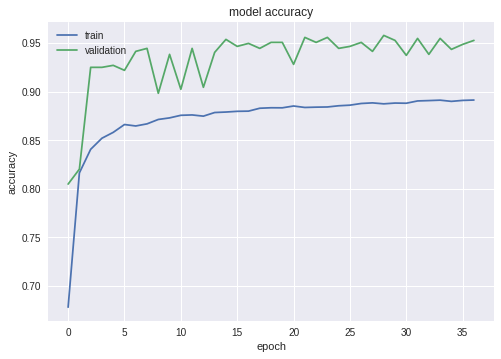

In [43]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


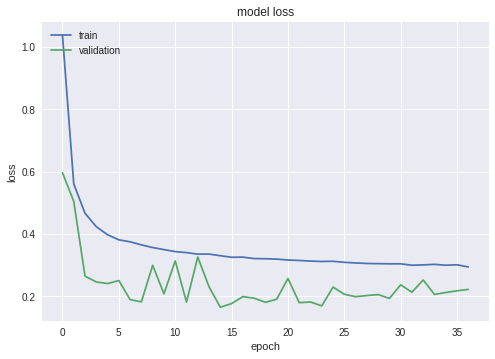

In [44]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Pretraind Model InceptionV3

In [0]:
InceptionV3_model = applications.InceptionV3(include_top=False, weights='imagenet',input_shape=(224,224,3),pooling='avg')


In [120]:
init_generators(224)

Found 16099 images belonging to 10 classes.
Found 973 images belonging to 10 classes.
Found 2486 images belonging to 10 classes.


In [0]:
save_bottleneck_features( InceptionV3_model,"InceptionV3")

## Training

In [87]:
sgd = optimizers.SGD(lr=0.01, clipnorm=1.,momentum=0.7)
top_model = train_top_model("InceptionV3",sgd)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 10)                2570      
Total params: 527,114
Trainable params: 527,114
Non-trainable params: 0
_________________________________________________________________
Train on 16099 samples, validate on 973 samples
Epoch 1/50
 - 5s - loss: 1.0268 - acc: 0.6689 - val_loss: 0.5023 - val_acc: 0.8376

Epoch 00001: val_acc improved from -inf to 0.83762, saving model to /content/Models/InceptionV3.h5
Epoch 2/50
 - 3s - loss: 0.5694 - acc: 0.8079 - val_loss: 0.3638 - val_acc: 0.8798

Epoch 00002: val_acc improved from 0.83762 to 0.87975, saving model to /content/Model

In [89]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'InceptionV3_before.h5'})
uploaded.SetContentFile('/content/Models/InceptionV3.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 14g-mqcwsMYXpLXJejYz8qRQawEEdliHk


## Testing

In [90]:
top_model.load_weights("/content/Models/InceptionV3.h5")
#loss and accuracy
test_top_model(top_model,"InceptionV3",2486)

2486/2486 [==============================] - 0s 79us/step
[0.18857386274891139, 0.9392598551890587]


## Visualization

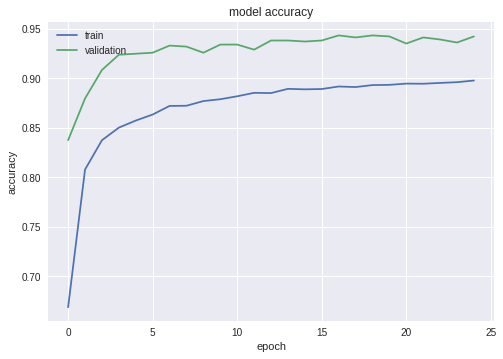

In [91]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


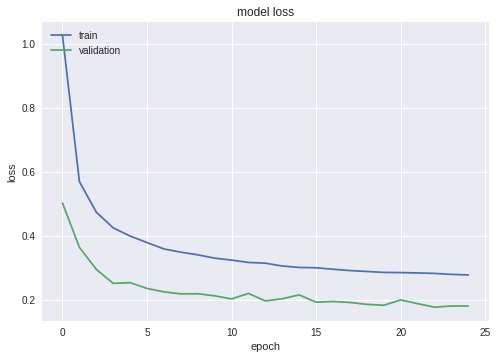

In [92]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## After Refinment (Best model)

In [123]:
RMS = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
top_model = train_top_model("InceptionV3",RMS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 10)                2570      
Total params: 527,114
Trainable params: 527,114
Non-trainable params: 0
_________________________________________________________________
Train on 16099 samples, validate on 973 samples
Epoch 1/50
 - 9s - loss: 0.7692 - acc: 0.7506 - val_loss: 0.8252 - val_acc: 0.7554

Epoch 00001: val_acc improved from -inf to 0.75540, saving model to /content/Models/InceptionV3.h5
Epoch 2/50
 - 3s - loss: 0.4649 - acc: 0.8370 - val_loss: 0.3476 - val_acc: 0.8962

Epoch 00002: val_acc improved from 0.75540 to 0.89620, saving model to /content/Model

In [125]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'InceptionV3_after.h5'})
uploaded.SetContentFile('/content/Models/InceptionV3.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1xP8Xlc6C3ZHYnxxK8ysljAzsNa5vzIeU


In [126]:
top_model.load_weights("/content/Models/InceptionV3.h5")
#loss and accuracy
test_top_model(top_model,"InceptionV3",2486)

2486/2486 [==============================] - 0s 103us/step
[0.3393180936279761, 0.9473049074818987]


## Visualization

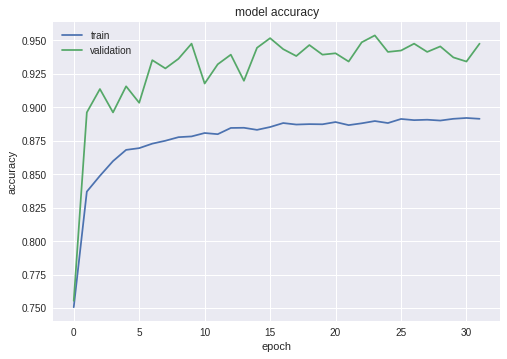

In [127]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


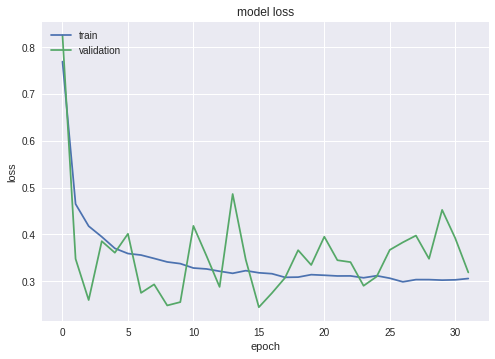

In [128]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#Sensitivity Analysis
I will change the size of images in dataset from 224 x 224 to 150 x 150  and see results

In [0]:
InceptionV3_model = applications.InceptionV3(include_top=False, weights='imagenet',input_shape=(150,150,3),pooling='avg')


In [93]:
init_generators(150)

Found 16099 images belonging to 10 classes.
Found 973 images belonging to 10 classes.
Found 2486 images belonging to 10 classes.


In [0]:
save_bottleneck_features( InceptionV3_model,"InceptionV3")

In [1]:
!ls -lh

total 4.0K
drwxr-xr-x 2 root root 4.0K Sep  6 17:46 sample_data


In [103]:
RMS = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
top_model = train_top_model("InceptionV3",RMS)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 10)                2570      
Total params: 527,114
Trainable params: 527,114
Non-trainable params: 0
_________________________________________________________________
Train on 16099 samples, validate on 973 samples
Epoch 1/50
 - 6s - loss: 1.1064 - acc: 0.6595 - val_loss: 0.6799 - val_acc: 0.7852

Epoch 00001: val_acc improved from -inf to 0.78520, saving model to /content/Models/InceptionV3.h5
Epoch 2/50
 - 3s - loss: 0.6825 - acc: 0.7681 - val_loss: 0.5763 - val_acc: 0.8294

Epoch 00002: val_acc improved from 0.78520 to 0.82939, saving model to /content/Model

In [104]:
# Create & upload a file.
uploaded = drive.CreateFile({'title': 'InceptionV3_robust.h5'})
uploaded.SetContentFile('/content/Models/InceptionV3.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1eW8NbWbMtDy4jai1iX7h3fcupGAgSK2m


## Testing

In [105]:
top_model.load_weights("/content/Models/InceptionV3.h5")
#loss and accuracy
test_top_model(top_model,"InceptionV3",2486)

2486/2486 [==============================] - 0s 84us/step
[0.7857259058199482, 0.879324215703306]


## Visualization

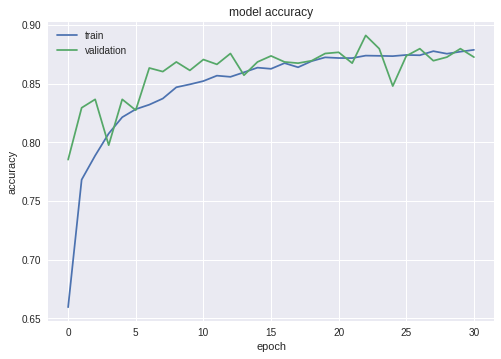

In [106]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


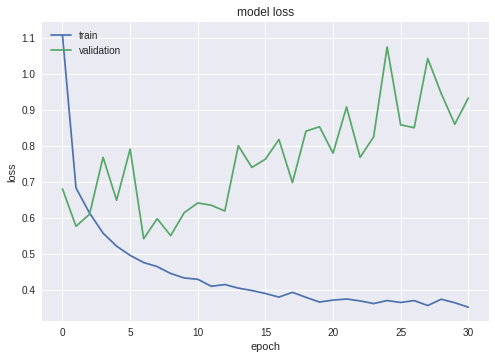

In [107]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()